# CNN

In [1]:
import tensorflow.keras as keras

In [2]:
# Módulos necesarios. Asegurarse de poder importarlos.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pylab import rcParams
from scipy import stats
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
import os as os
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from time import time

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
tf.__version__

/usr/bin/python
3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


'1.14.0'

In [4]:
keras.__version__

'2.2.4-tf'

# 10-FOLD

In [5]:
subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
global activities
activities = [9,10,11,12,13,19,20,21,24,25,31]

In [6]:
# Ajustado a los datos
n_time_steps = 128
n_classes = 11 # Nº de clases (el 0 está eliminado)
n_channels = 1 # Nº de canales
n_columns = 20

# Podríamos variarlo
batch_size = 128 # Tamaño del batch
learning_rate = 1e-3 # Learning rate (por defecto es 0.001)
epochs = 100 # Épocas

In [7]:
class LearningRateDecay:
    def plot(self, epochs, title="Learning Rate Schedule"):
        # compute the set of learning rates for each correRPonding
        # epoch
        lrs = [self(i) for i in epochs]
 
        # the learning rate schedule
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(epochs, lrs)
        plt.title(title)
        plt.xlabel("Epoch #")
        plt.ylabel("Learning Rate")
class StepDecay(LearningRateDecay):
    def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
        # store the base initial learning rate, drop factor, and
        # epochs to drop every
        self.initAlpha = initAlpha
        self.factor = factor
        self.dropEvery = dropEvery
 
    def __call__(self, epoch):
        # compute the learning rate for the current epoch
        exp = np.floor((1 + epoch) / self.dropEvery)
        alpha = self.initAlpha * (self.factor ** exp)
        if(alpha<1e-9):
            alpha=1e-9

        # return the learning rate
        return float(alpha) 

schedule = StepDecay(initAlpha=learning_rate, factor=0.4, dropEvery=10)

reduce_lr = keras.callbacks.LearningRateScheduler(schedule, verbose = 1)
callbacks_list = [reduce_lr]

In [8]:
#Visualize training evolution
def plot_curves(model, acc, loss, val_acc, val_loss, kfold):
    #########################################################################################
    # LOSS plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[loss], label='Training loss')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Loss in trainnig', fontsize=20)
    fig = plt.gcf()
    plt.show()
    
    fig.savefig('./01AUGNORM_RP_KFOLD_models/loss_train_01AUGNORM_RP_KFOLD_models_KFOLD_'+kfold+'.pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./01AUGNORM_RP_KFOLD_models/loss_train_01AUGNORM_RP_KFOLD_models_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC plot
    plt.figure(figsize=(12,8))
    plt.plot(model.history.history[acc], label='Training accuracy')
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.tick_params(labelsize=10)
    plt.legend(loc=1,prop={'size': 10})
    plt.title('Accuracy in training', fontsize=20)
    fig = plt.gcf()
    plt.show()

    fig.savefig('./01AUGNORM_RP_KFOLD_models/acc_train_01AUGNORM_RP_KFOLD_models_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./01AUGNORM_RP_KFOLD_models/acc_train_01AUGNORM_RP_KFOLD_models_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')
    
    #########################################################################################
    # ACC+LOSS plot
    plt.figure(figsize=(14,10))
    plt_loss = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    plt_acc = plt_loss.twinx()
    plt_acc.axis["right"].toggle(all=True)
    
    plt_loss.set_xlim(0, len(model.history.history[loss]))
    plt_loss.set_ylim(0, max(model.history.history[loss]))
    plt_loss.set_xlabel('Epochs')
    plt_loss.set_ylabel('Loss')
    plt_acc.set_ylabel('Accuracy')
                        
    plt_loss.axis['left'].label.set_fontsize(15)
    plt_loss.axis['bottom'].label.set_fontsize(15)
    plt_acc.axis['right'].label.set_fontsize(15)
    
    plt_loss.plot(model.history.history[loss], c='tab:blue', ls='--', label='Training loss')
    plt_acc.plot(model.history.history[acc], c='tab:orange',ls='--', label='Training accuracy')
    
    plt.tick_params(labelsize=10)
    plt.title('Training performance', fontsize=20)
    plt_acc.set_ylim(0, 1)
    plt_loss.legend(loc=1, prop={'size': 10})
    
    fig = plt.gcf()
    plt.show()

    fig.savefig('./01AUGNORM_RP_KFOLD_models/all_train_01AUGNORM_RP_KFOLD_models_KFOLD_'+kfold+'pdf', bbox_inches='tight',format='pdf')
    fig.savefig('./01AUGNORM_RP_KFOLD_models/all_train_01AUGNORM_RP_KFOLD_models_KFOLD_'+kfold+'svg', bbox_inches='tight',format='svg')

In [9]:
def plot_confusion_matrix(y_true, y_pred, kfold, classes,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, square = True, robust = True, annot=True, cmap='YlOrBr')
    plt.title('CONFUSION MATRIX')
    plt.ylabel('TRUE ACTIVITY')
    plt.xlabel('PREDICTION')
    
    locs, labels = plt.xticks()
    plt.xticks(locs, labels, rotation='vertical')
    locs, labels = plt.yticks()
    plt.yticks(locs, labels, rotation='horizontal')

    # Guardamos la imagen en formato vectorial
    plt.draw()
    plt.savefig('./01AUGNORM_RP_KFOLD_models/matriz_confusion_'+kfold+'.svg', bbox_inches='tight',format='svg')
    plt.show()

In [10]:
global size
size = 26125

In [11]:
from sklearn.model_selection import KFold
S = np.arange(0,size)
kf = KFold(n_splits=10)
kf.get_n_splits(S)

print(kf)  

S_train = []
S_test = []

for train_index, test_index in kf.split(S):
    print("TRAIN:", train_index, "TEST:", test_index)
    print(S[train_index])
    print(S[test_index])
    S_train.append(S[train_index])
    S_test.append(S[test_index])

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 2613  2614  2615 ... 26122 26123 26124] TEST: [   0    1    2 ... 2610 2611 2612]
[ 2613  2614  2615 ... 26122 26123 26124]
[   0    1    2 ... 2610 2611 2612]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [2613 2614 2615 ... 5223 5224 5225]
[    0     1     2 ... 26122 26123 26124]
[2613 2614 2615 ... 5223 5224 5225]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [5226 5227 5228 ... 7836 7837 7838]
[    0     1     2 ... 26122 26123 26124]
[5226 5227 5228 ... 7836 7837 7838]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [ 7839  7840  7841 ... 10449 10450 10451]
[    0     1     2 ... 26122 26123 26124]
[ 7839  7840  7841 ... 10449 10450 10451]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [10452 10453 10454 ... 13062 13063 13064]
[    0     1     2 ... 26122 26123 26124]
[10452 10453 10454 ... 13062 13063 13064]
TRAIN: [    0     1     2 ... 26122 26123 26124] TEST: [13065 13066 13067 ... 

##################################################################################################################################
#####################################################  K-FOLD 1  ################################################################
Train dataset: 
(23512, 1, 128, 20) (23512, 11)
Test dataset: 
(2613, 1, 128, 20) (2613, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


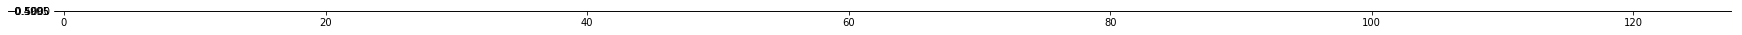

Activity:  12


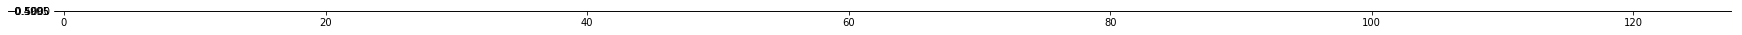

Activity:  25
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 5)         0       

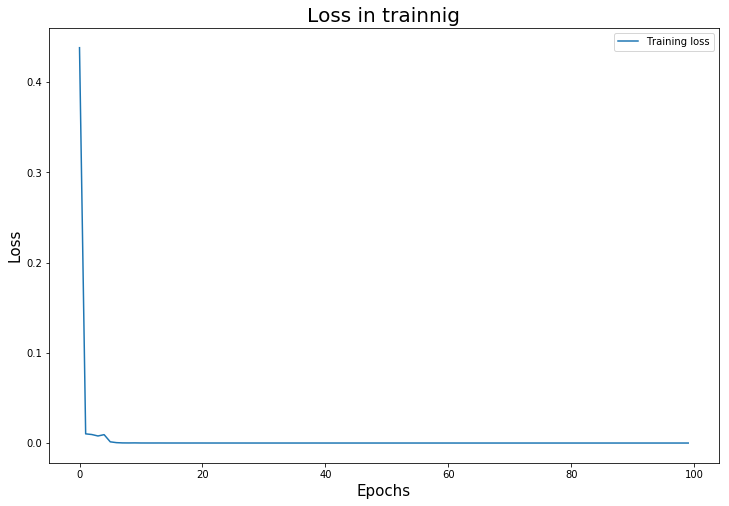

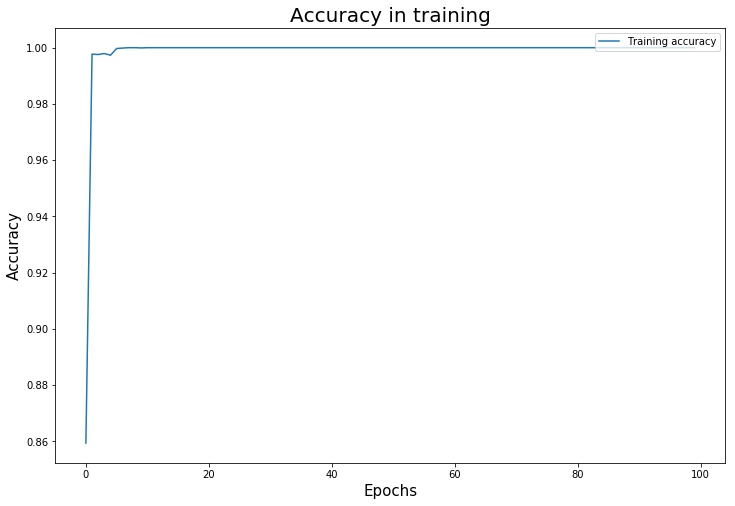

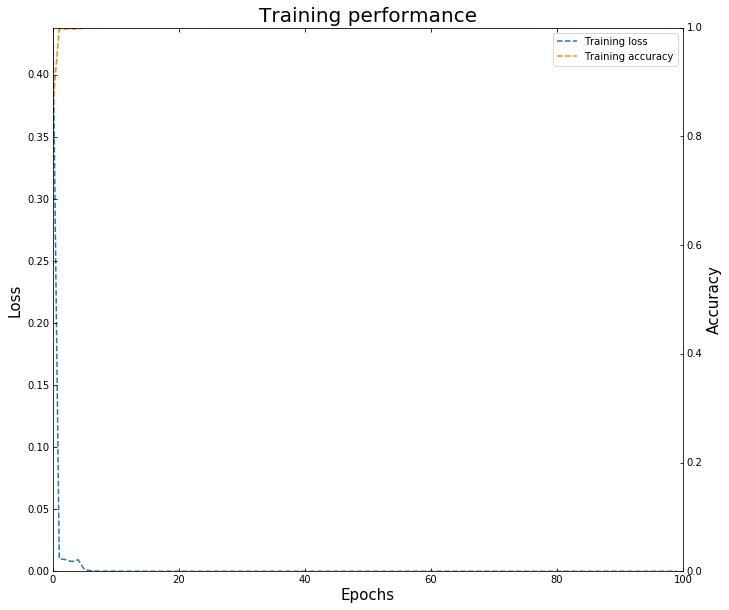

2613/2613 [==============================] - 0s 100us/sample
(2613, 11)
[[ 4 10  3  4  5 10  4  0  3  7  7 10  0  3  0  5  1  5  5  1  7 10 10  4
   3  0  2  4  0  0  7  4  0  5  5 10  4  5  6  9 10 10  9  3  3  7  0  7
   1  1  4  0  2  4  2  0  2  6  3  0  2  3  0  9  0 10  5  9  7 10  5  3
   0  7  5  2  2  8  1  5  7 10 10  1  1  0  3  3  1  1  9  4  0  0 10  1
   5  0  4  2]]
(2613, 1)
[[ 4 10  3  4  5 10  4  8  4  7  9 10  8  4  8  5  1  5  5  1  9 10 10  4
   3  9  2  4  0  0  9  4  0  5  5 10  4  5  6  9  8  8  9  1  1  7  6  7
   1  1  4  6  2  4  2  8  2  6  4  8  2  3  0  9  0 10  5  9  7 10  6  1
   6  7  5  2  2  8  1  9  7 10 10  1  1  6  3  3  1  1  9  4  0  0 10  1
   9  0  4  2]]
2613/2613 [==============================] - 0s 112us/sample - loss: 1.6177 - categorical_accuracy: 0.7612


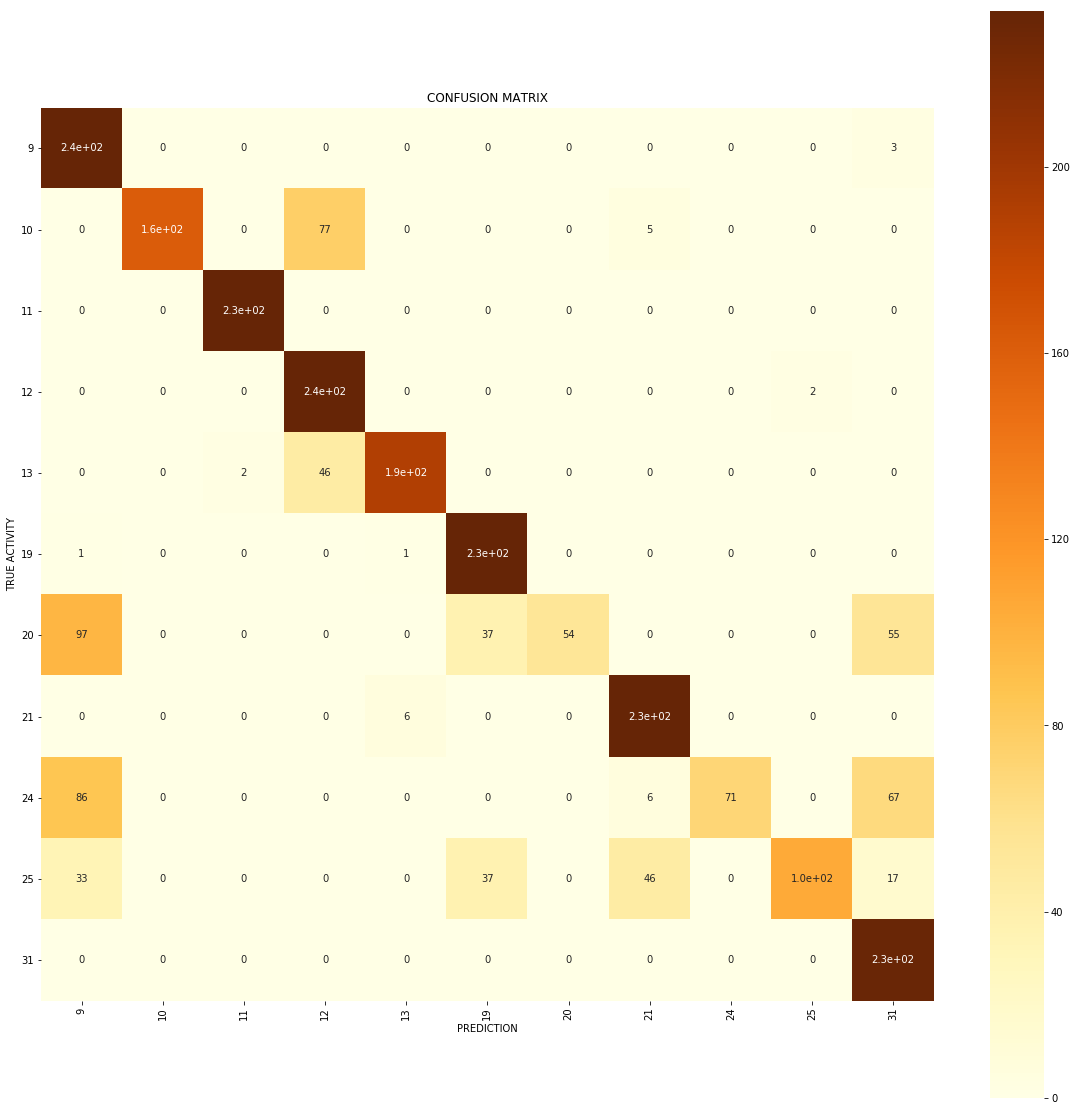

##################################################################################################################################
#####################################################  K-FOLD 2  ################################################################
Train dataset: 
(23512, 1, 128, 20) (23512, 11)
Test dataset: 
(2613, 1, 128, 20) (2613, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


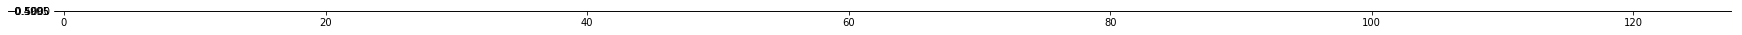

Activity:  13


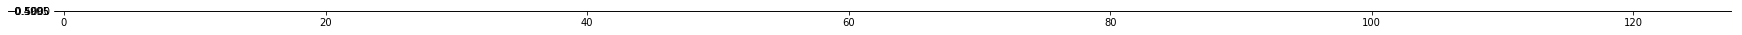

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 5)   

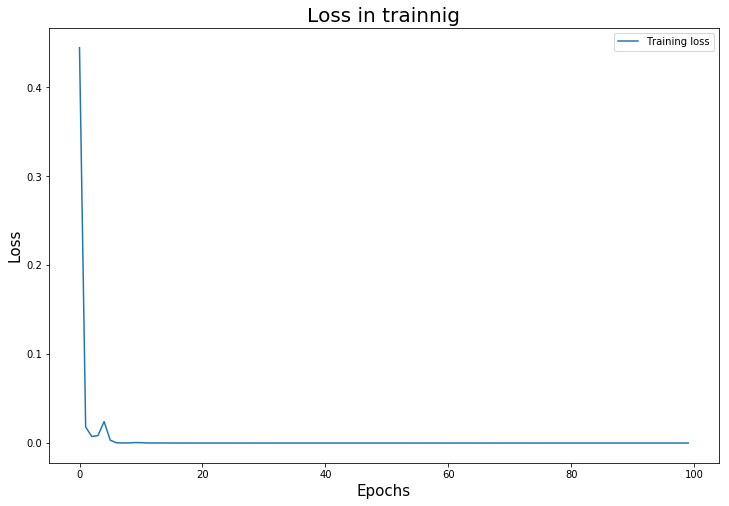

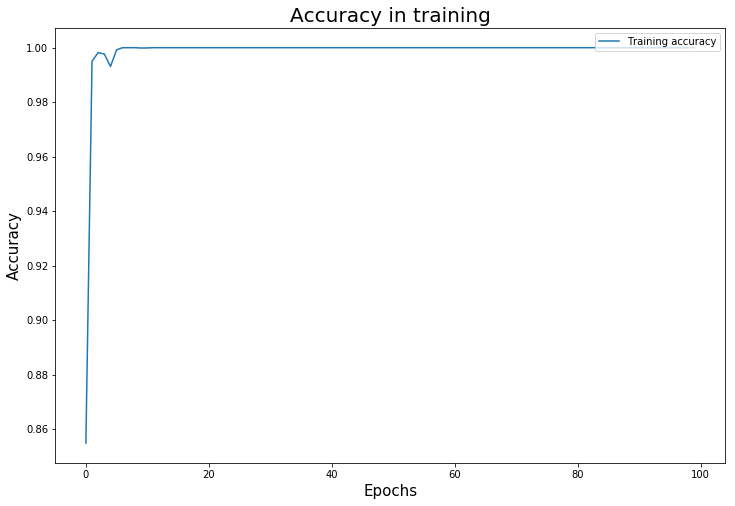

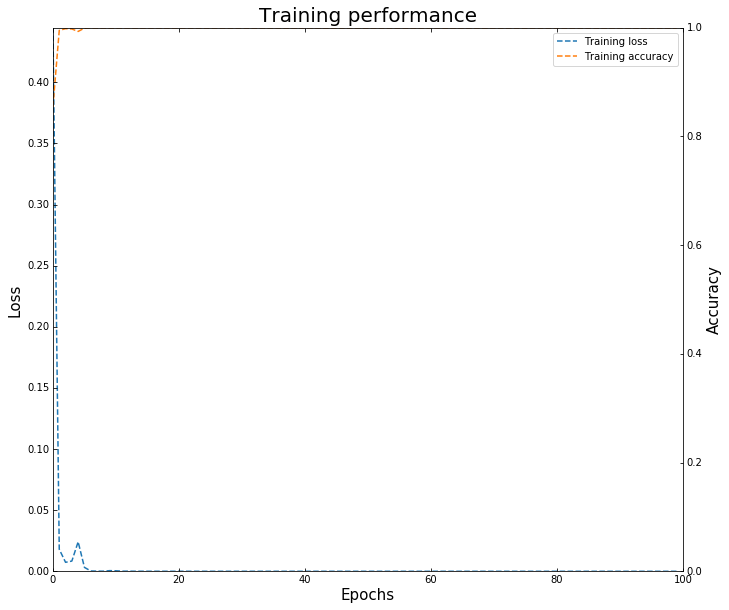

2613/2613 [==============================] - 0s 90us/sample
(2613, 11)
[[ 3  1  7 10  7  3 10  8  4  1  9  6  0  3  4  1 10  9 10  9  9  8  8  7
   8 10  5  5  9  8  4  4  7  5 10  9  0  7 10  5  9  1  4  1  0 10  9  7
   0  2  6  0  2  3  5  1  7  6  7  9  7  3  8  2  2  0  3  4  0  4  8  1
   8  6  4  5  3  5  0  3  9  2  7  4 10  6  6  8 10  6  2  6  8  2  9  6
   9  4  6 10]]
(2613, 1)
[[ 3  1  7 10  7  3 10  8  4  1  9  6  0  3  4  1 10  9 10  9  9  8  8  7
   8 10  5  5  9  8  4  4  7  5 10  9  0  7 10  5  9  1  4  1  0 10  9  7
   0  2  6  0  2  3  5  1  7  6  7  9  7  3  8  2  2  0  3  4  0  4  8  1
   8  6  4  5  3  5  0  3  9  2  7  4 10  6  6  8 10  6  2  6  8  2  9  6
   9  4  6 10]]
2613/2613 [==============================] - 0s 105us/sample - loss: 1.2195e-04 - categorical_accuracy: 1.0000


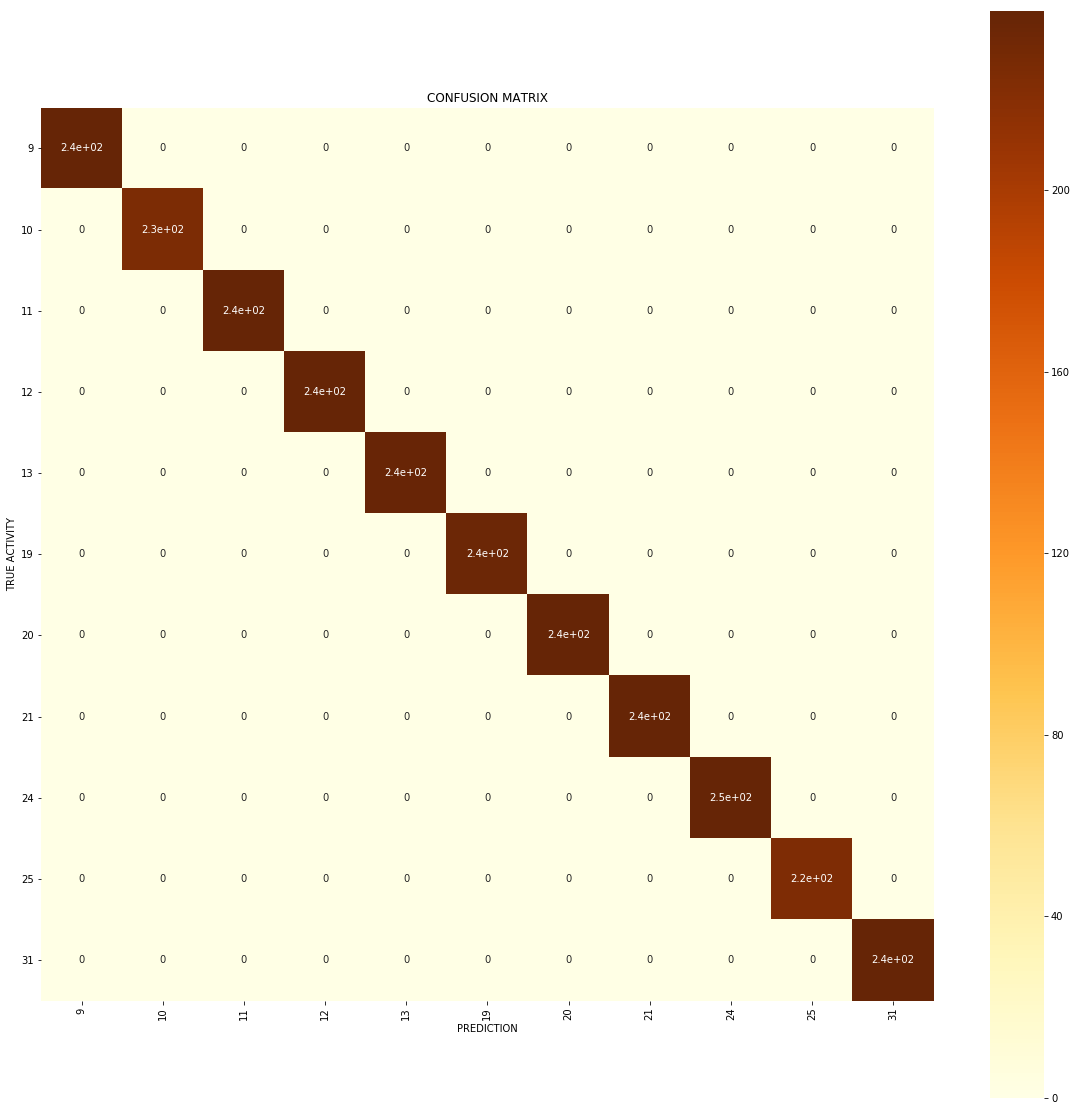

##################################################################################################################################
#####################################################  K-FOLD 3  ################################################################
Train dataset: 
(23512, 1, 128, 20) (23512, 11)
Test dataset: 
(2613, 1, 128, 20) (2613, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


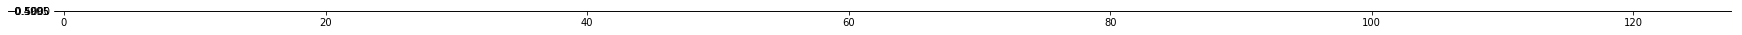

Activity:  13


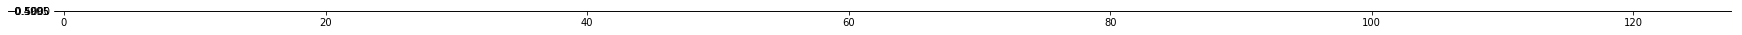

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 5)   

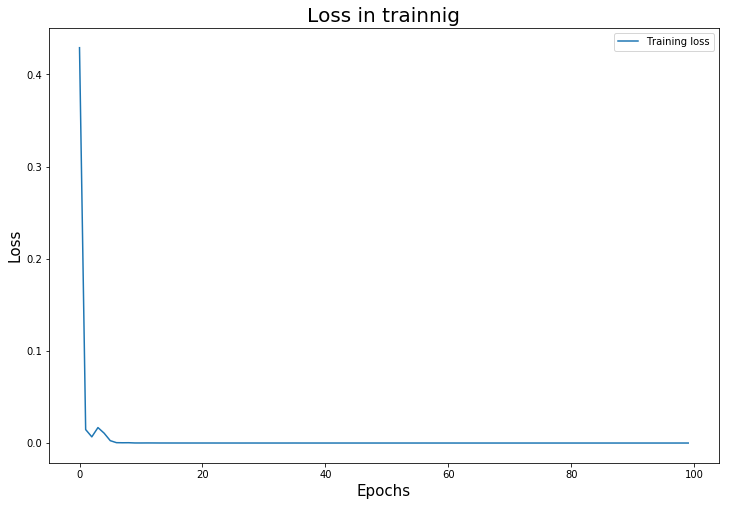

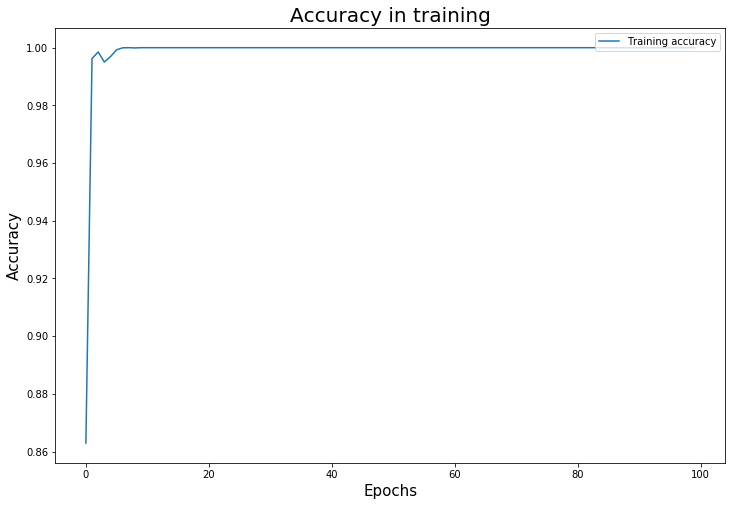

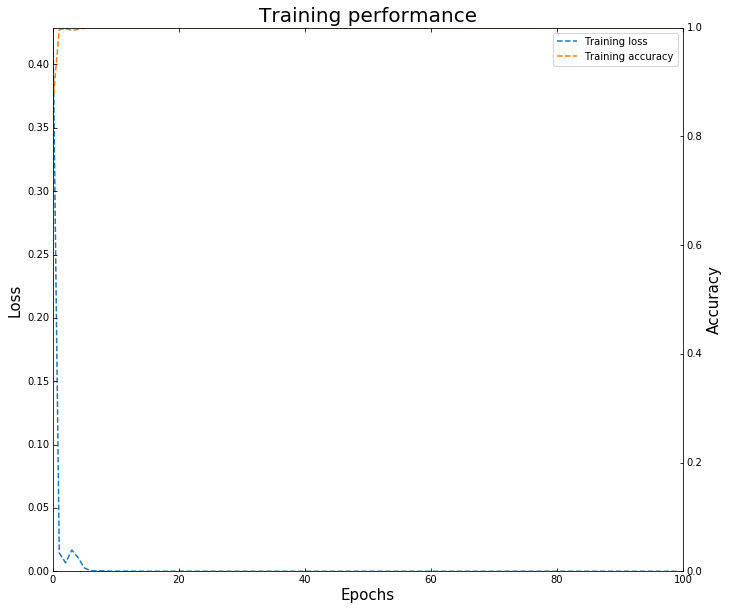

2613/2613 [==============================] - 0s 95us/sample
(2613, 11)
[[ 2  1  0  3  0  1  3  9  3  6 10  8  5  4  2  2  1  0  0  9  5  6  9  4
   4  7  1  6  7  5 10 10  8  0  1  4  7  8  5  2  8 10  9  9  7  8 10 10
   3  6  3  7  4  0 10  5  3  4  6  7  5  2  6  2  2  4  9  7  6 10  7  3
   4  8  6 10  6  2  1  1  8 10  3  7  0  9  8  9  3  5  7  4  3  7 10  2
   0 10  7  5]]
(2613, 1)
[[ 2  1  0  3  0  1  3  9  3  6 10  8  5  4  2  2  1  0  0  9  5  6  9  4
   4  7  1  6  7  5 10 10  8  0  1  4  7  8  5  2  8 10  9  9  7  8 10 10
   3  6  3  7  4  0 10  5  3  4  6  7  5  2  6  2  2  4  9  7  6 10  7  3
   4  8  6 10  6  2  1  1  8 10  3  7  0  9  8  9  3  5  7  4  3  7 10  2
   0 10  7  5]]
2613/2613 [==============================] - 0s 113us/sample - loss: 5.2094e-06 - categorical_accuracy: 1.0000


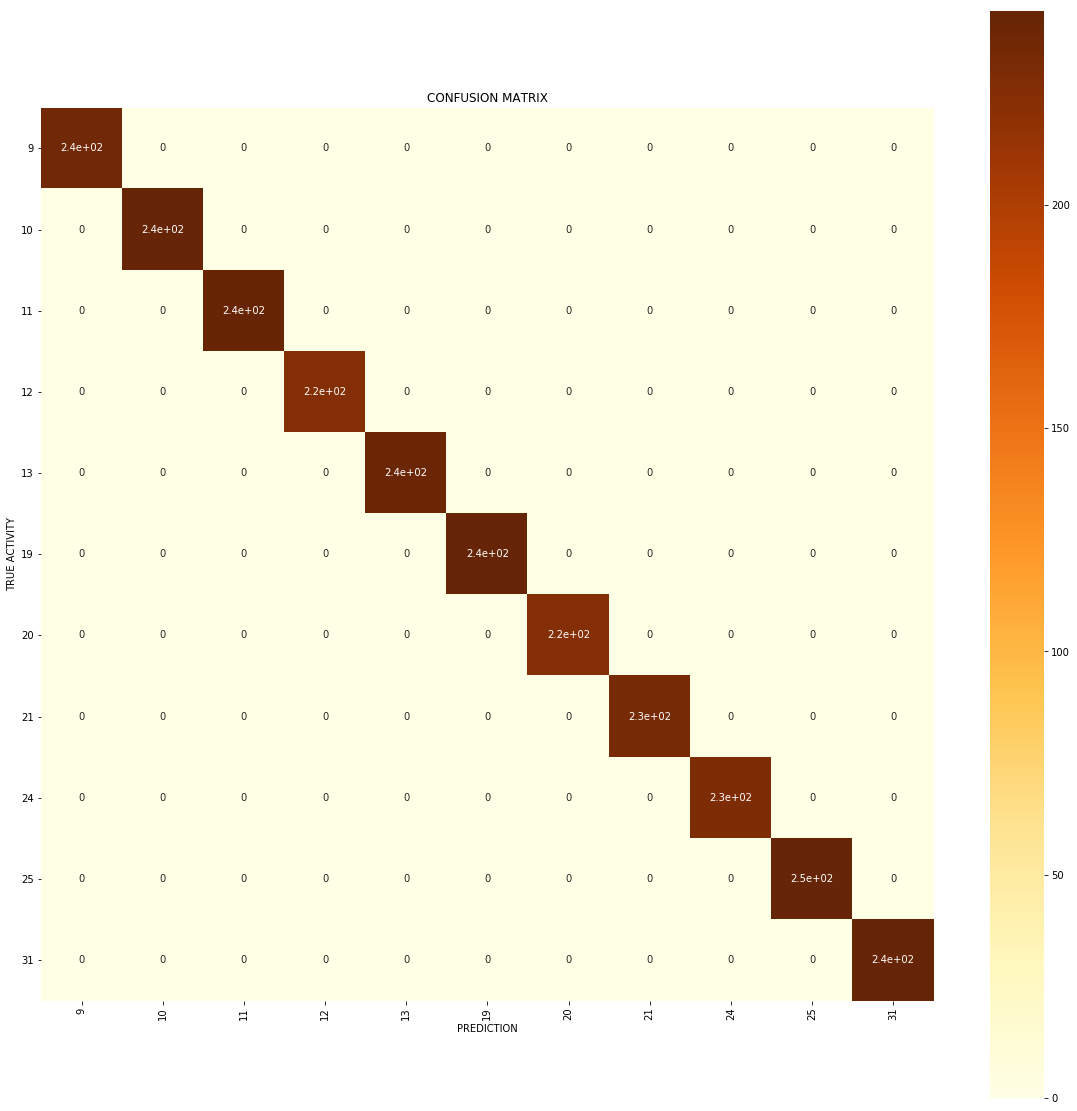

##################################################################################################################################
#####################################################  K-FOLD 4  ################################################################
Train dataset: 
(23512, 1, 128, 20) (23512, 11)
Test dataset: 
(2613, 1, 128, 20) (2613, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


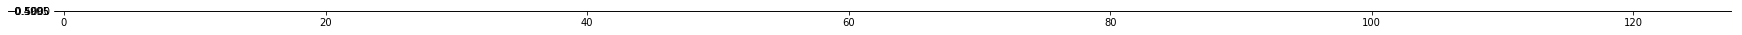

Activity:  13


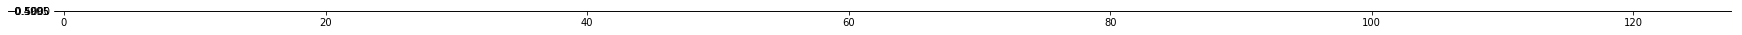

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 5)   

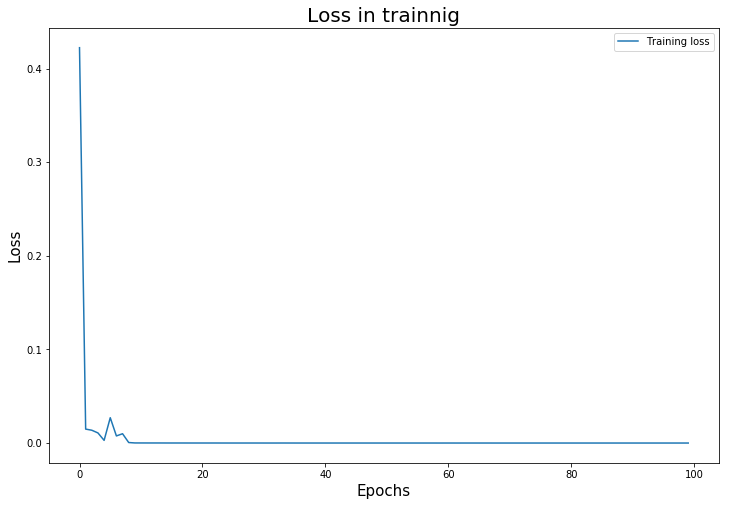

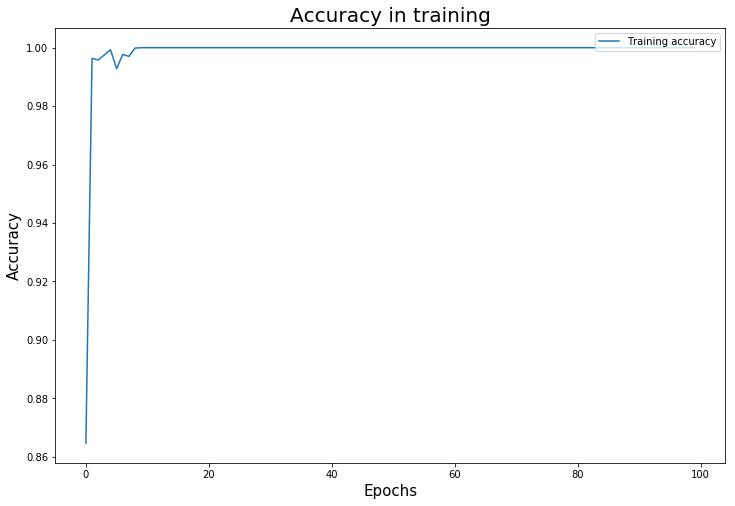

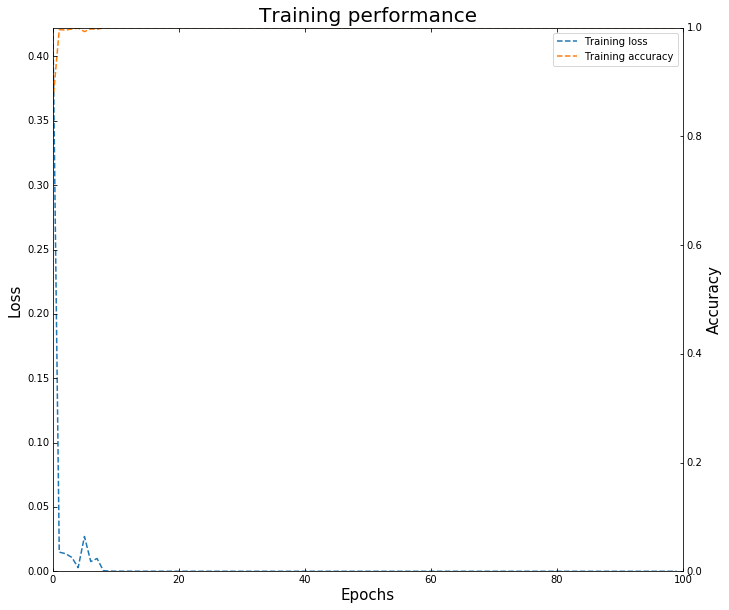

2613/2613 [==============================] - 0s 103us/sample
(2613, 11)
[[ 6 10 10  6  0  7  6  4  9  1  9  9  7  0  6  6  5 10  7  9  1  3  6  8
   0  5  0  0  0  3  6 10  9  3  7  4  7  7  4  0  4  7  9  1  6  1  8  1
   3  8  0 10  3 10  1  6  2  7  8  5  5  5  2  6  5  0  5  9  0  4  0  8
   0  0  4  6  3  7  3 10  2  4  5  3  6  8  4  4  8  3  3  6  4  9  6  5
   9  3  8  2]]
(2613, 1)
[[ 6 10 10  6  0  7  6  4  9  1  9  9  7  0  6  6  5 10  7  9  1  3  6  8
   0  5  0  0  0  3  6 10  9  3  7  4  7  7  4  0  4  7  9  1  6  1  8  1
   3  8  0 10  3 10  1  6  2  7  8  5  5  5  2  6  5  0  5  9  0  4  0  8
   0  0  4  6  3  7  3 10  2  4  5  3  6  8  4  4  8  3  3  6  4  9  6  5
   9  3  8  2]]
2613/2613 [==============================] - 0s 119us/sample - loss: 3.8275e-06 - categorical_accuracy: 1.0000


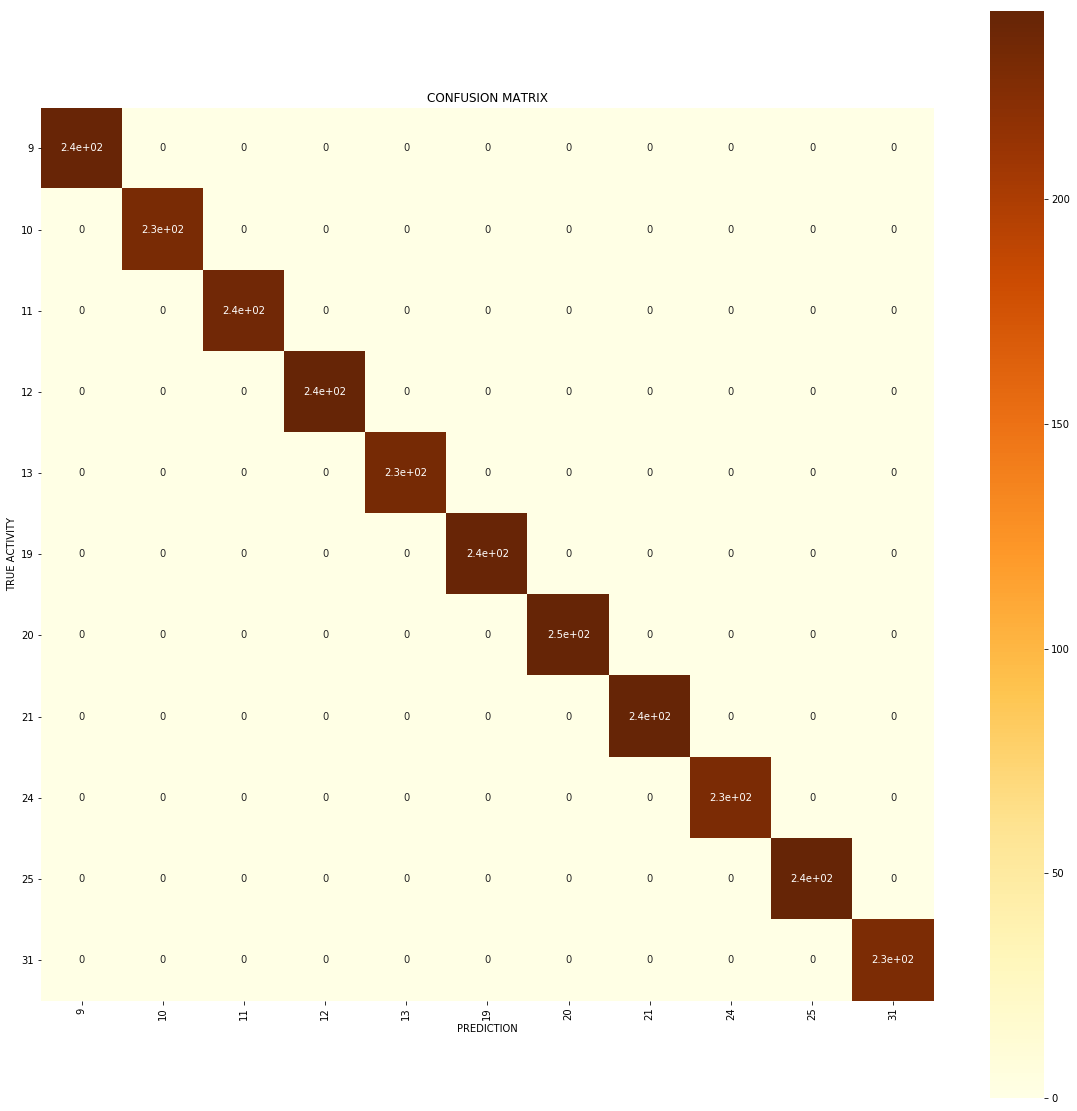

##################################################################################################################################
#####################################################  K-FOLD 5  ################################################################
Train dataset: 
(23512, 1, 128, 20) (23512, 11)
Test dataset: 
(2613, 1, 128, 20) (2613, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


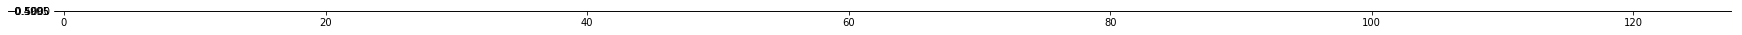

Activity:  13


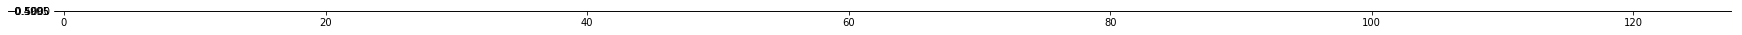

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 5)   

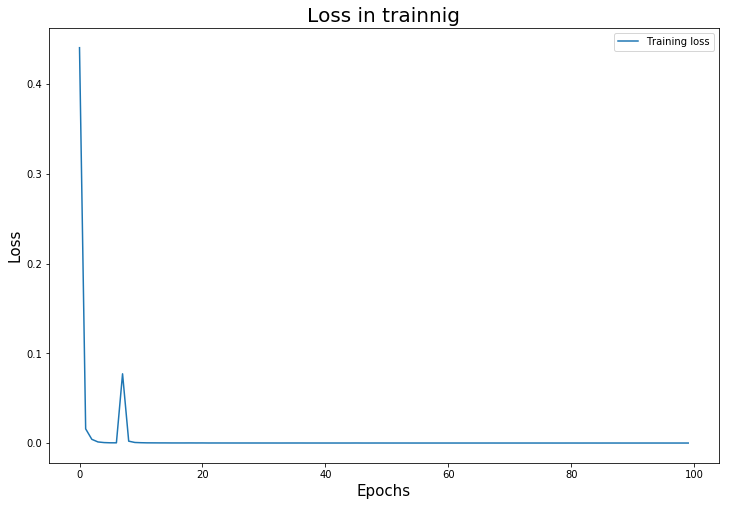

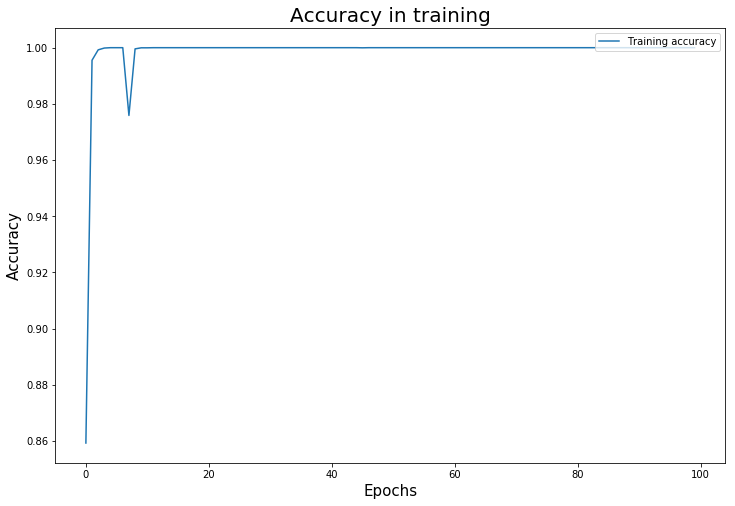

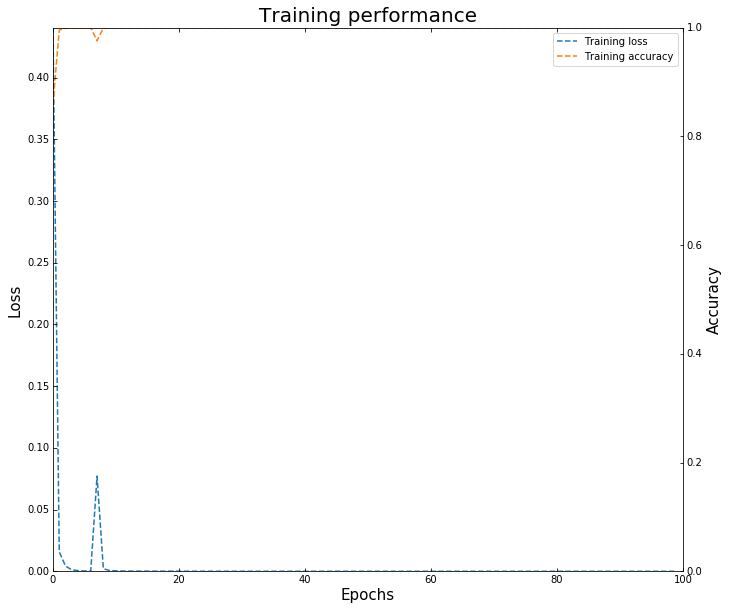

2613/2613 [==============================] - 0s 113us/sample
(2613, 11)
[[ 2  2  3  5  9  0 10  8  8  7  4  3  7  4  8  7  0  0  6  2  8  7  9  0
  10  6 10  8  7  9  4  8  8 10  5  7  4  8  8  0  8  9  2  9  6  1  9 10
   3  1  3 10  9  2  6  6  6  5  5  1  9  6  1  0  2  3  6  2 10  6  9  4
   6  6  7  8  6  1  8  1  0  3  8  5  5  4  0  0  8  4 10  9  3  9 10 10
   0  3  6  6]]
(2613, 1)
[[ 2  2  3  5  9  0 10  8  8  7  4  3  7  4  8  7  0  0  6  2  8  7  9  0
  10  6 10  8  7  9  4  8  8 10  5  7  4  8  8  0  8  9  2  9  6  1  9 10
   3  1  3 10  9  2  6  6  6  5  5  1  9  6  1  0  2  3  6  2 10  6  9  4
   6  6  7  8  6  1  8  1  0  3  8  5  5  4  0  0  8  4 10  9  3  9 10 10
   0  3  6  6]]
2613/2613 [==============================] - 0s 125us/sample - loss: 4.6320e-06 - categorical_accuracy: 1.0000


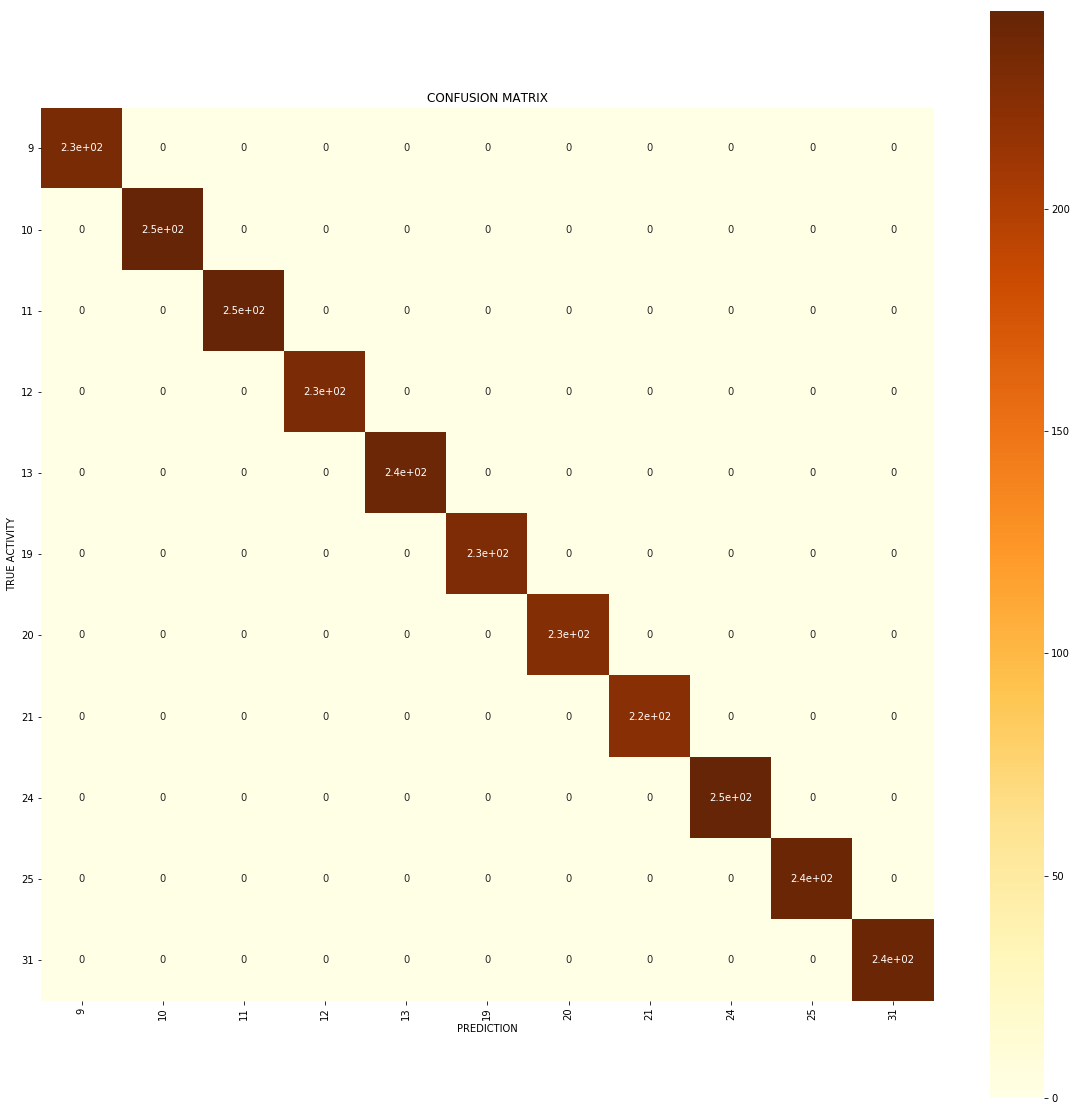

##################################################################################################################################
#####################################################  K-FOLD 6  ################################################################
Train dataset: 
(23513, 1, 128, 20) (23513, 11)
Test dataset: 
(2612, 1, 128, 20) (2612, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


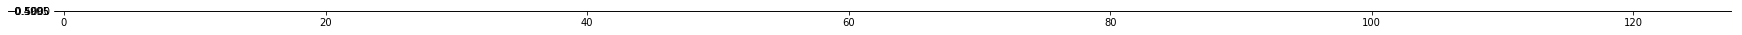

Activity:  13


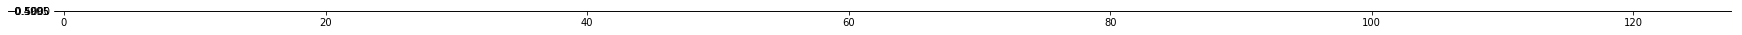

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 5)   

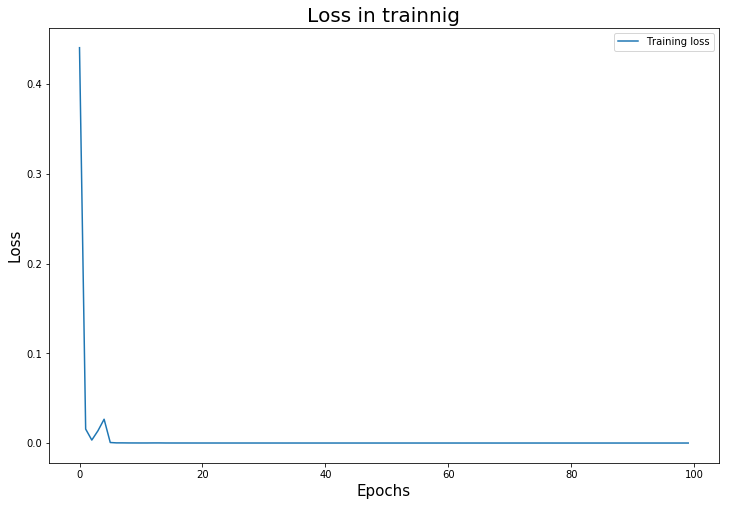

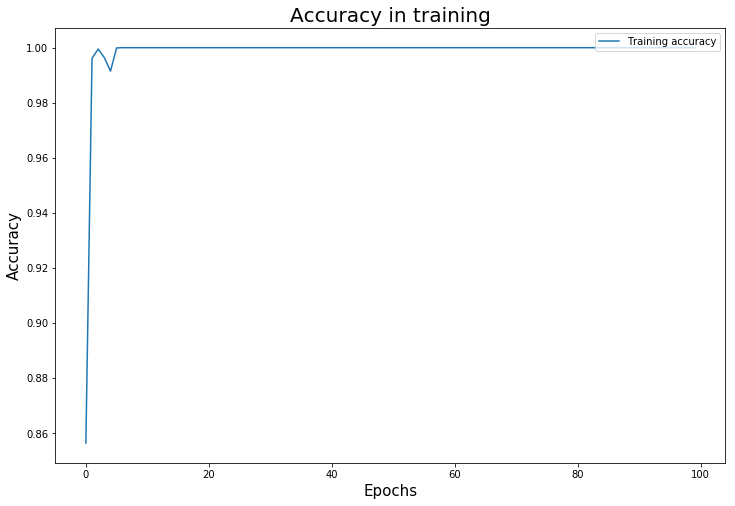

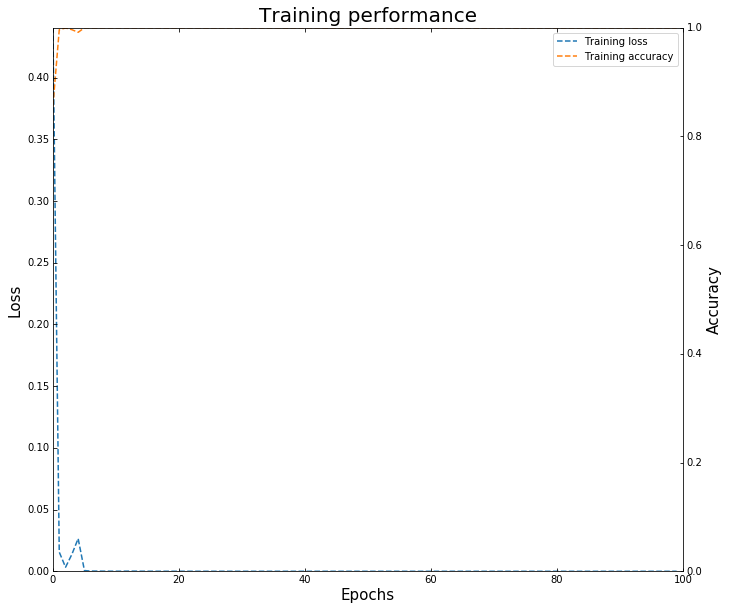

2612/2612 [==============================] - 0s 133us/sample
(2612, 11)
[[ 7  6  9  0  3  1  0  3  9  2  8  7 10  5  9  4  0  7  2  4  6  9  0  6
  10  9  0  9  3  8  1  8  0  2  6  5  2  2  8  6  6  1 10  5  3  5  2  6
   0  4  3  9  3  8  3  8  1  1  4  6  4 10  4  7  8  5  3  1 10  5 10  3
   0  4  6  2  0  6  3  5  3  0  3  2 10  5 10  5 10  1  4  0  8  8  3  8
   9  8  9 10]]
(2612, 1)
[[ 7  6  9  0  3  1  0  3  9  2  8  7 10  5  9  4  0  7  2  4  6  9  0  6
  10  9  0  9  3  8  1  8  0  2  6  5  2  2  8  6  6  1 10  5  3  5  2  6
   0  4  3  9  3  8  3  8  1  1  4  6  4 10  4  7  8  5  3  1 10  5 10  3
   0  4  6  2  0  6  3  5  3  0  3  2 10  5 10  5 10  1  4  0  8  8  3  8
   9  8  9 10]]
2612/2612 [==============================] - 0s 148us/sample - loss: 3.1374e-06 - categorical_accuracy: 1.0000


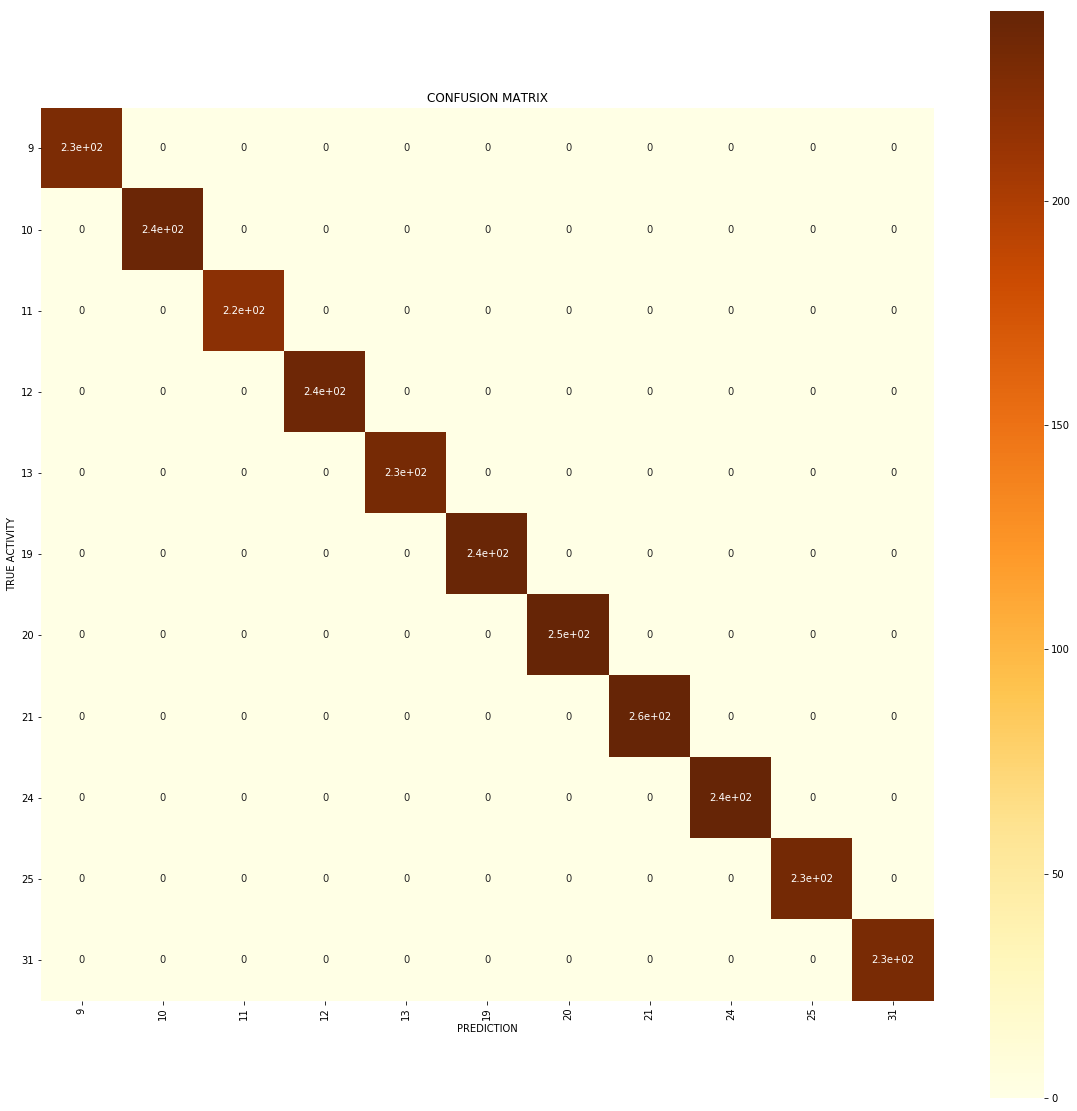

##################################################################################################################################
#####################################################  K-FOLD 7  ################################################################
Train dataset: 
(23513, 1, 128, 20) (23513, 11)
Test dataset: 
(2612, 1, 128, 20) (2612, 11)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


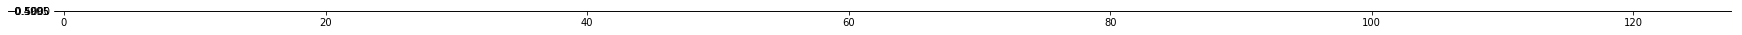

Activity:  13


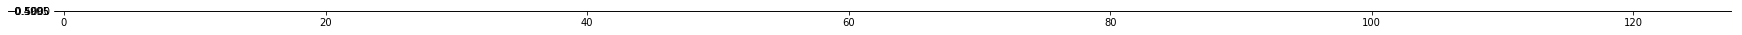

Activity:  25
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 128, 20)       272       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 64, 10)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 64, 10)        64        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 64, 10)        8224      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 5)         0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 5)   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23513/23513 [==============================] - 3s 143us/sample - loss: 0.0268 - categorical_accuracy: 0.9916

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/100
23513/23513 [==============================] - 3s 143us/sample - loss: 0.0026 - categorical_accuracy: 0.9996

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/100
23513/23513 [==============================] - 3s 143us/sample - loss: 0.0050 - categorical_accuracy: 0.9985

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/100
23513/23513 [==============================] - 3s 143us/sample - loss: 0.0166 - categorical_accuracy: 0.9954

Epoch 00006: LearningRateScheduler reducing learning rate to 0.001.
Epoch 6/100
23513/23513 [==============================] - 3s 143us/sample - loss: 0.0046 - categorical_accuracy: 0.9988

Epoch 00007: LearningRateScheduler reducing learning rate to 0.001.
Epoch 7/100
23513/23513 [==============================] - 3s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23513/23513 [==============================] - 3s 142us/sample - loss: 0.0149 - categorical_accuracy: 0.9952

Epoch 00008: LearningRateScheduler reducing learning rate to 0.001.
Epoch 8/100
23513/23513 [==============================] - 3s 142us/sample - loss: 0.0041 - categorical_accuracy: 0.9988

Epoch 00009: LearningRateScheduler reducing learning rate to 0.001.
Epoch 9/100
23513/23513 [==============================] - 3s 142us/sample - loss: 3.8096e-04 - categorical_accuracy: 1.0000

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 10/100
23513/23513 [==============================] - 3s 143us/sample - loss: 2.0165e-04 - categorical_accuracy: 0.9999

Epoch 00011: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 11/100
23513/23513 [==============================] - 3s 143us/sample - loss: 8.3072e-05 - categorical_accuracy: 1.0000

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 12/100
23513/23513 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



23513/23513 [==============================] - 3s 146us/sample - loss: 4.2616e-05 - categorical_accuracy: 1.0000

Epoch 00018: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 18/100
23513/23513 [==============================] - 3s 146us/sample - loss: 4.3977e-05 - categorical_accuracy: 1.0000

Epoch 00019: LearningRateScheduler reducing learning rate to 0.0004.
Epoch 19/100
23513/23513 [==============================] - 3s 146us/sample - loss: 3.0593e-05 - categorical_accuracy: 1.0000

Epoch 00020: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 20/100
23513/23513 [==============================] - 3s 146us/sample - loss: 2.8600e-05 - categorical_accuracy: 1.0000

Epoch 00021: LearningRateScheduler reducing learning rate to 0.00016000000000000004.
Epoch 21/100
23513/23513 [==============================] - 3s 146us/sample - loss: 2.7553e-05 - categorical_accuracy: 1.0000

Epoch 00022: LearningRateScheduler reducing learning rate to 0.0001600

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
accuracies = []
for i in range(10):
    if(i<10):
        kfold='0'+str(i)
    else:
        kfold=str(i)
    print('##################################################################################################################################')
    print('#####################################################  K-FOLD %d  ################################################################'%(i+1))
    
    subjects = ['01', '02', '03', '05', '08', '09', '10', '11', '13', '14', '16', '17']
    
    ##  GENERACIÓN DATASET
    tr_seg = np.concatenate((np.load('./augment_norm/subject_'+subjects[0]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[1]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[2]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[3]+'_seg.npy'),
                             np.load('./augment_norm/subject_'+subjects[4]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[5]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[6]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[7]+'_seg.npy'),
                             np.load('./augment_norm/subject_'+subjects[8]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[9]+'_seg.npy'),np.load('./augment_norm/subject_'+subjects[10]+'_seg.npy')))

    tr_lab = np.concatenate((np.load('./augment_norm/subject_'+subjects[0]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[1]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[2]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[3]+'_lab.npy'),
                             np.load('./augment_norm/subject_'+subjects[4]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[5]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[6]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[7]+'_lab.npy'),
                             np.load('./augment_norm/subject_'+subjects[8]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[9]+'_lab.npy'),np.load('./augment_norm/subject_'+subjects[10]+'_lab.npy')))
    
    limit = 20
    tr_seg = tr_seg[:,:,:,:limit]
    ####################################################################################################################
    ## SHUFFLE DE DATOS
    np.random.seed(235)
    tr_seg = np.reshape(tr_seg[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (size,1,128,limit))
    tr_lab = np.reshape(tr_lab[np.random.shuffle(np.arange(0,tr_seg.shape[0]))], (size,11))
    
    ts_seg = tr_seg[S_test[i]]
    ts_lab = tr_lab[S_test[i]]
    
    tr_seg = tr_seg[S_train[i]]
    tr_lab = tr_lab[S_train[i]]
    
    print('Train dataset: ')
    print(tr_seg.shape, tr_lab.shape)
    print('Test dataset: ')
    print(ts_seg.shape, ts_lab.shape)
    ####################################################################################################################
    ## VISTA DE DFT-2D
    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.abs(np.fft.fftshift(tr_seg[0,0,:,20:40].T))**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[0])])

    plt.figure(figsize=(30,30))
    plt.imshow(np.log(np.fft.fftshift(tr_seg[10,0,:,20:40].T)**2))
    plt.show()
    print('Activity: ',activities[np.argmax(tr_lab[10])])
    ####################################################################################################################
    ## RED
    quat_input = keras.Input(shape=(n_channels, n_time_steps, n_columns), name='input_layer')

    # Initializer
    #initializer = RandomNormal(mean=0.0, stddev=0.02)

    # Some convolutional layers
    conv_1 = keras.layers.Conv2D(16, activation='relu', kernel_size=4,padding='same',strides=1,data_format='channels_first')(quat_input)#, kernel_initializer=initializer)(quat_input)
    max_1 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_1)
    bn_1 = keras.layers.BatchNormalization(axis=1)(max_1)

    conv_2 = keras.layers.Conv2D(32, activation='relu', kernel_size=4,padding='same',strides=1,data_format='channels_first')(bn_1)#, kernel_initializer=initializer)(max_1)
    max_2 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_2)
    bn_2 = keras.layers.BatchNormalization(axis=1)(max_2)

    conv_3 = keras.layers.Conv2D(64, activation='relu', kernel_size=4,padding='same',strides=1,data_format='channels_first')(bn_2)#, kernel_initializer=initializer)(re_2)
    max_3 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_3)
    bn_3 = keras.layers.BatchNormalization(axis=1)(max_3)

    conv_4 = keras.layers.Conv2D(128, activation='relu', kernel_size=4,padding='same',strides=1,data_format='channels_first')(bn_3)#, kernel_initializer=initializer)(re_2)
    max_4 = keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same', data_format = 'channels_first')(conv_4)
    bn_4 = keras.layers.BatchNormalization(axis=1)(max_4)

    # Flatten the output of the convolutional layers
    conv_flat = keras.layers.Flatten()(bn_4)

    dr_2 = keras.layers.Dropout(0.5)(conv_flat)

    # Output layers: separate outputs for the weather and the ground labels
    multiclass_output = keras.layers.Dense(n_classes, activation='softmax',name='activity_class')(dr_2)

    # Creamos la estrcutura que contendrá a nuestro modelo
    model = keras.Model(inputs=quat_input, outputs=[multiclass_output],name='cnn')

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    print(model.summary())
    ####################################################################################################################
    ## TRAIN
    history = model.fit(tr_seg,
                        tr_lab,
                        epochs = epochs,
                        steps_per_epoch = None,
                        verbose = 1,
                        batch_size = batch_size,
                        callbacks = callbacks_list)
    model.save('./01AUGNORM_RP_KFOLD_models/CNN_'+kfold+'.h5')
    
    #Visualize training evolution
    plot_curves(model, 'categorical_accuracy', 'loss', 'val_categorical_accuracy', 'val_loss', kfold)
    ####################################################################################################################
    ## TEST
    predictions = model.predict(ts_seg, batch_size = batch_size, verbose = 1)
    
    print(predictions.shape)
    
    y_pred = np.argmax(predictions,axis=-1)
    y_pred = np.expand_dims(y_pred,axis=-1)
    print(y_pred[:100].T)
    
    y_true = np.argmax(ts_lab,axis=-1)
    y_true = np.expand_dims(y_true,axis=-1)
    print(y_true.shape)
    print(y_true[:100].T)
    
    evaluation = model.evaluate(ts_seg, ts_lab, batch_size=batch_size, verbose=1)
    accuracies.append(evaluation[1])
    
    fo = open('./01AUGNORM_RP_KFOLD_models/accuracy_'+kfold+'.txt', "w")
    fo.seek(0,2)
    fo.write(str(evaluation))
    fo.close()
    
    ####################################################################################################################
    ## CONFUSION MATRIX
    y_true_flat = np.ndarray.flatten(y_true)
    y_pred_flat = np.ndarray.flatten(y_pred)
    
    plot_confusion_matrix(y_true_flat, y_pred_flat, kfold, classes=activities)
    
    del kfold, limit, tr_seg, tr_lab, ts_seg, ts_lab, model, history, y_pred, y_true, predictions, evaluation, y_true_flat, y_pred_flat
    

# Accuracy

In [15]:
sum = 0
for acc in accuracies:
    sum += acc
print('Accuracy of K-Fold: ' + str(sum/10))

Accuracy of K-Fold: 0.9716017961502075
